# Indicator Validation
This notebook is aimed at assisting developers with tracking large scale indicator changes beyond what can be picked up by the unit tests. While unit tests perform local sanity checks on the operations, the tests here will be more qualitative in nature, comparing the live version of an indicator with the propagating changes.

## Usage
Since each indicator will have different points of interest, this notebook will only provide a framework to get started. The goal is to support the comparison of the dataframes resulting from the data cleaning and shaping that our indicator code provides.

In [143]:
import os
from datetime import date
import covidcast
from os import listdir
from os.path import isfile, join, basename
from datetime import datetime
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Set your base directory (assuming this notebook is run from "covidcast_indicators/testing_utils/")
os.chdir("../")
ROOT_DIR = os.getcwd()

def read_relevant_date_filenames(data_path, date_slist):
    """
    Return a list of tuples of every filename in the specified directory if the file is in the specified date range.
    Arguments:
        - data_path: path to the directory containing CSV data files.
        - date_slist: list of dates (formatted as strings) to check
    Returns:
        - list
    """
    all_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]
    filenames = list()

    for fl in all_files:
        for dt in date_slist:
            if fl.find(dt) != -1:
                filenames.append(fl)
    return filenames

def generate_date_range(start, end):
    """
    Return a list of string-formatted dates in the format YYYYMMDD from start to end, both ends inclusive.

    Parameters
    ----------
    start: str
        The start date in the same string format as above.
    end: str
        The end date in the same string format as above.

    Return
    ---------
    List of dates.
    """
    return [x.strftime("%Y%m%d") for x in pd.date_range(start, end)]

def filter_filenames(filename_list, geocode, signal_type):
    """
    Return a sublist of filename_list consisting of the filenames that contain geocode and signal_type.
    """
    return [x for x in filename_list if geocode in x and signal_type in x]

def load_csvs(filename_list):
    """
    Returns a list of dataframes for each csv file in the list. Each dataframe is appended with a date column
    that contains the date in the first 8 characters of the filename with the format YYYYMMDD.
    """
    all_frames = []
    for filename in filename_list:
        frame = pd.read_csv(join("receiving", filename), dtype={"geo_id": str, "val": float, "se": float, "sample_size": float})
        frame["date"] = datetime(
            int(basename(filename)[:4]),
            int(basename(filename)[4:6]),
            int(basename(filename)[6:8])
        )
        all_frames.append(frame)
    return all_frames


## Installation
Install the utilities and the relevant indicator as needed.

In [3]:
os.chdir(join(ROOT_DIR, "_delphi_utils_python"))
!pip install -e .
os.chdir(join(ROOT_DIR, "jhu"))
!pip install -e .

on-&gt;delphi-utils==0.0.1) (3.0.4)
  Attempting uninstall: delphi-utils
    Found existing installation: delphi-utils 0.0.1
    Uninstalling delphi-utils-0.0.1:
      Successfully uninstalled delphi-utils-0.0.1
  Running setup.py develop for delphi-utils
You should consider upgrading via the &#39;/home/dskel/.pyenv/versions/3.8.5/envs/delphi/bin/python3.8 -m pip install --upgrade pip&#39; command.
Obtaining file:///home/dskel/Code/covidcast-indicators/jhu
  Attempting uninstall: delphi-jhu
    Found existing installation: delphi-jhu 0.0.1
    Uninstalling delphi-jhu-0.0.1:
      Successfully uninstalled delphi-jhu-0.0.1
  Running setup.py develop for delphi-jhu
You should consider upgrading via the &#39;/home/dskel/.pyenv/versions/3.8.5/envs/delphi/bin/python3.8 -m pip install --upgrade pip&#39; command.


## Run the indicator

In [3]:
os.chdir(join(ROOT_DIR, "jhu"))
!python -m delphi_jhu

deaths fips new_counts unsmoothed
deaths fips new_counts seven_day_average
deaths fips cumulative_counts unsmoothed
deaths fips cumulative_counts seven_day_average
deaths fips incidence unsmoothed
deaths fips incidence seven_day_average
deaths fips cumulative_prop unsmoothed
deaths fips cumulative_prop seven_day_average
deaths state new_counts unsmoothed
deaths state new_counts seven_day_average
deaths state cumulative_counts unsmoothed
deaths state cumulative_counts seven_day_average
deaths state incidence unsmoothed
deaths state incidence seven_day_average
deaths state cumulative_prop unsmoothed
deaths state cumulative_prop seven_day_average
deaths msa new_counts unsmoothed
deaths msa new_counts seven_day_average
deaths msa cumulative_counts unsmoothed
deaths msa cumulative_counts seven_day_average
deaths msa incidence unsmoothed
deaths msa incidence seven_day_average
deaths msa cumulative_prop unsmoothed
deaths msa cumulative_prop seven_day_average
deaths hrr new_counts unsmoothed
d

## Qualitative Comparisons


### Load FIPS Level Data
Local data is the data generated by your local branch. Remote data is the data as it is currently being served by the API. Both are loaded into a single dataframe below to use for plot comparisons.

In [191]:
os.chdir(join(ROOT_DIR, "jhu"))
geocode = "fips"
signal_type = "confirmed_incidence_num"
start_date = date(2020, 3, 1)
end_date = date(2020, 10, 1)
local_data = pd.concat(
        load_csvs(
            filter_filenames(
                read_relevant_date_filenames(
                    "receiving", 
                    generate_date_range(
                        start_date.strftime("%Y%m%d"), 
                        end_date.strftime("%Y%m%d")
                    )
                ),
                geocode,
                signal_type
            )
        )
    )

remote_data_filename = join(ROOT_DIR, "testing_utils", ( 
    start_date.strftime("%Y%m%d") + 
    "_" + 
    end_date.strftime("%Y%m%d") + 
    "jhu-csse_" + 
    "confirmed_incidence_num_" + 
    "county.csv"
))
if not isfile(remote_data_filename):
    remote_data = covidcast.signal("jhu-csse", "confirmed_incidence_num",
                            start_date, end_date,
                            "county")
    remote_data.to_csv(remote_data_filename)
else:
    remote_data = pd.read_csv(remote_data_filename)
remote_data["time_value"] = pd.to_datetime(remote_data["time_value"])
remote_data["geo_value"] = remote_data["geo_value"].astype(str)

### FIPS Level Plots
The first few plots are select codes of interest, since they changed in this release.

Total difference:  0.0


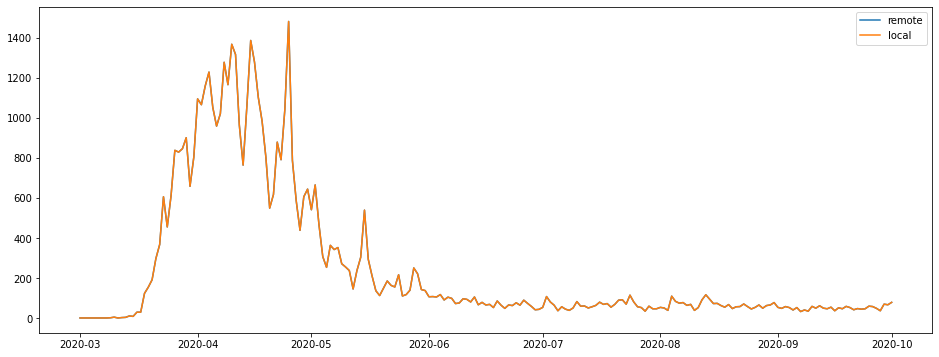

In [192]:
fips_code = "36005" # Bronx County, New York FIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

Total difference:  0.0


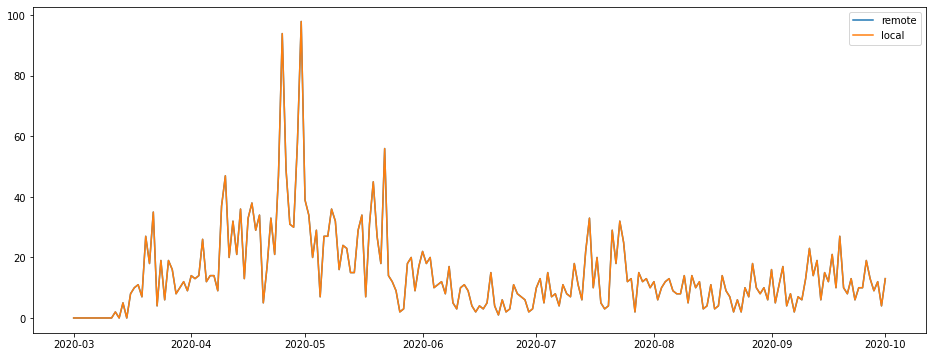

In [193]:
fips_code = "36001" # Albany County, New York FIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

Total difference:  -10067.0


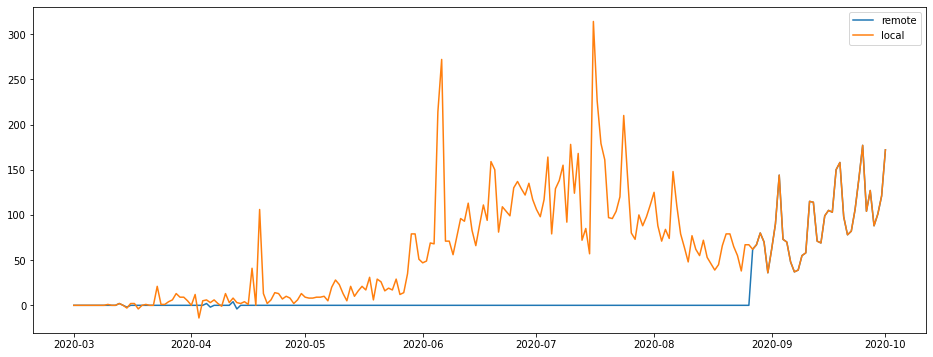

In [194]:
fips_code = "49000" # Utah megaFIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

Total difference:  0.0


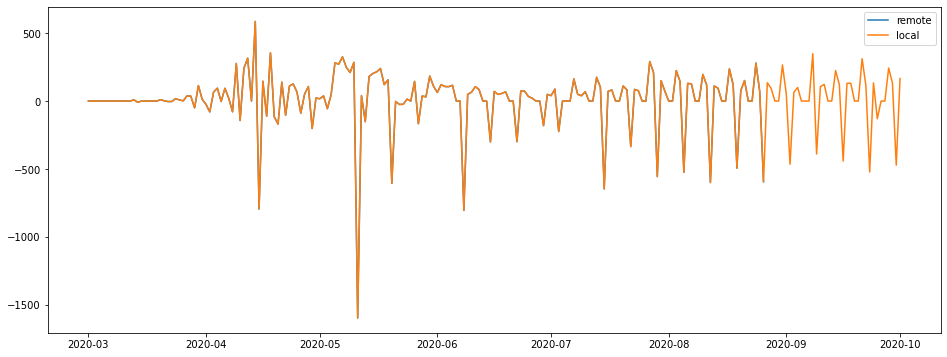

In [195]:
fips_code = "44000" # Rhode Island megaFIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

Total difference:  0.0


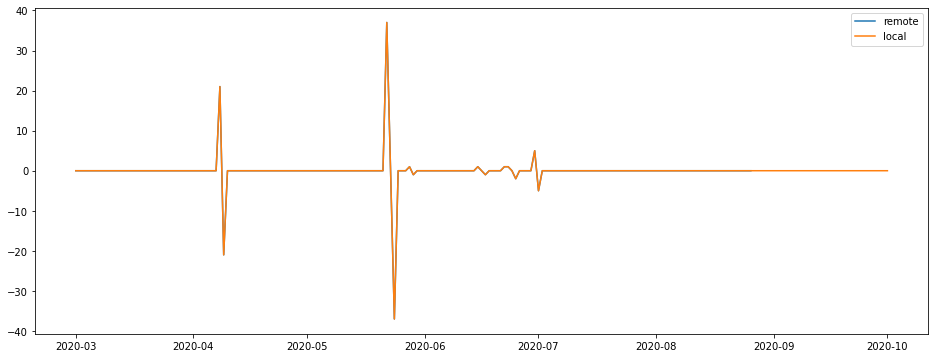

In [196]:
fips_code = "54000" # Wyoming megaFIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

Total difference:  -6359.437624493385


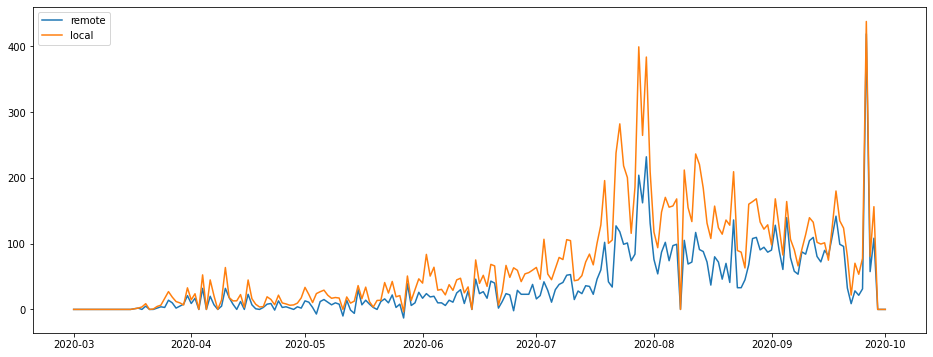

In [197]:
fips_code = "29095" # Jackson County, Kansas City FIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

Total difference:  10498.0


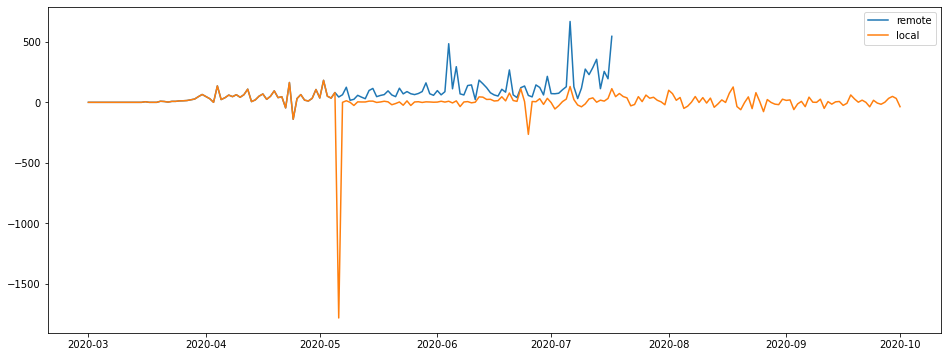

In [198]:
fips_code = "72000" # Puerto Rico megaFIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

Total difference:  0.0


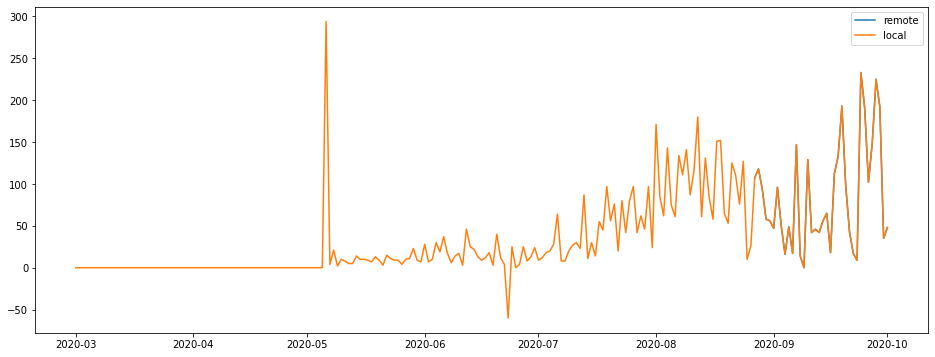

In [199]:
fips_code = "72127" # San Juan, Puerto Rico megaFIPS
rd = remote_data[remote_data["geo_value"] == fips_code].set_index("time_value").sort_index()["value"]
ld = local_data[local_data["geo_id"] == fips_code].set_index("date").sort_index()["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

The rest of these are automatically detected outliers.

Max percent difference for 13000 0.7552334943639292
Max percent difference for 15000 0.3
Max percent difference for 25000 0.996390977443609
Max percent difference for 25007 2.0262307804899624
Max percent difference for 25019 1.24649649223731
Max percent difference for 26000 0.3415492957746479
Max percent difference for 29037 0.4552056618434723
Max percent difference for 29047 1.0277671852719648
Max percent difference for 29095 0.4659593301511424
Max percent difference for 29165 0.5022086465613166
Max percent difference for 49000 1.7740112994350283
Max percent difference for 72000 2.7324364723467864


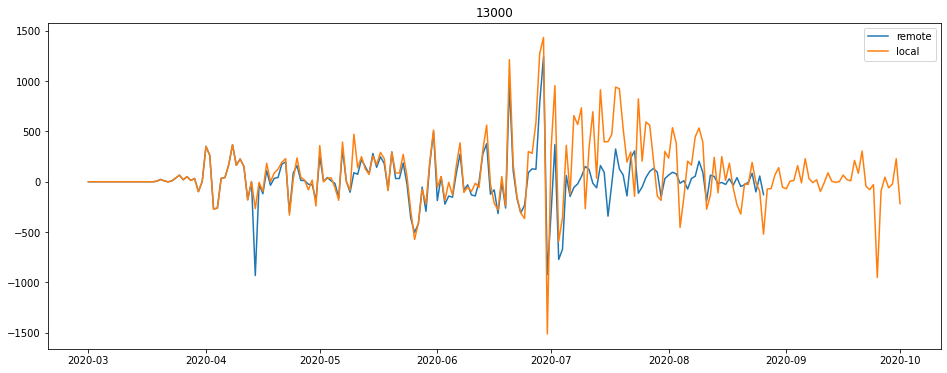

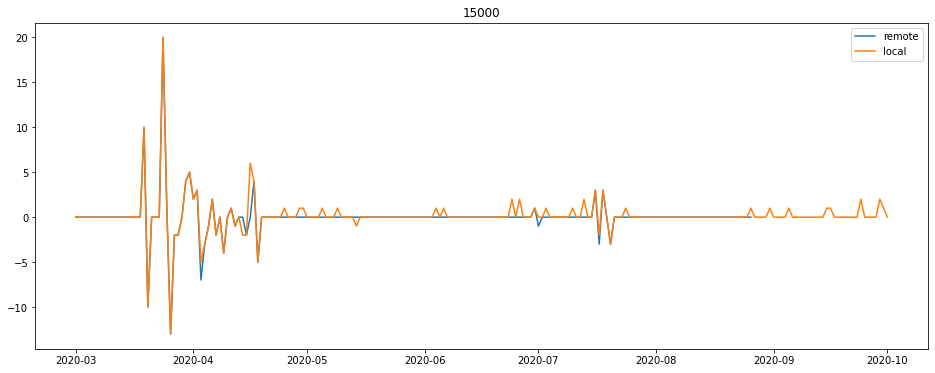

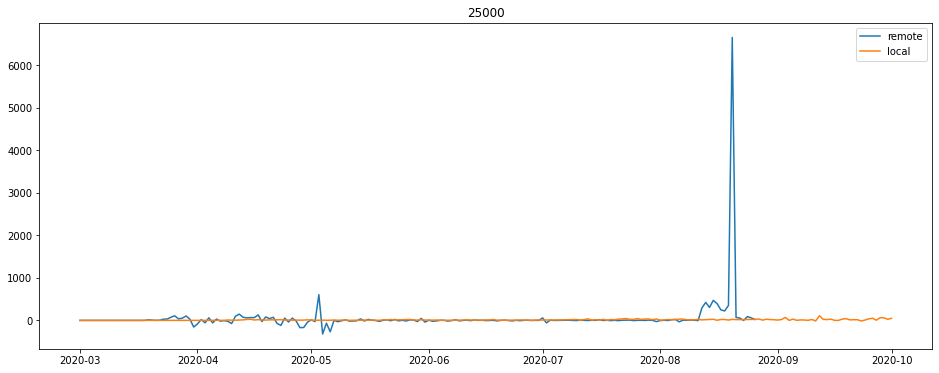

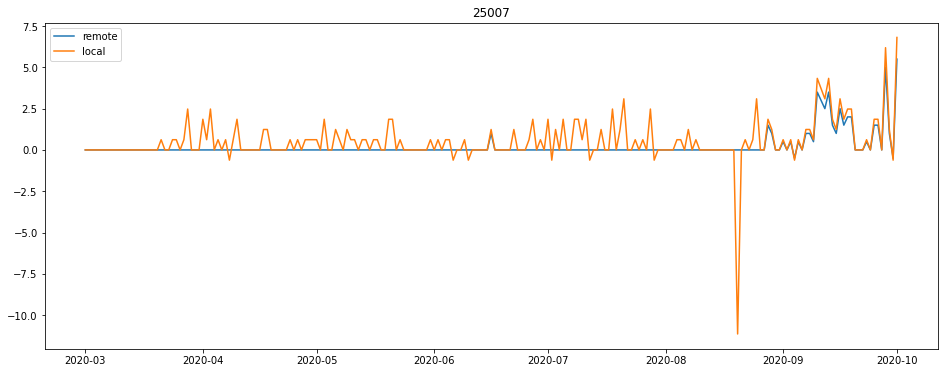

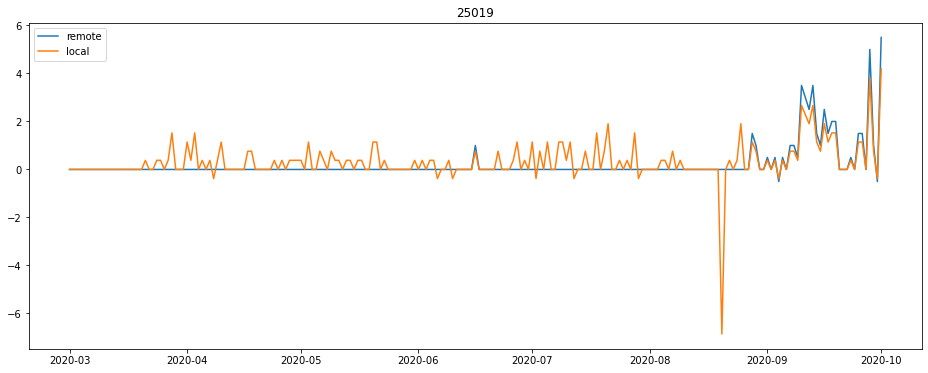

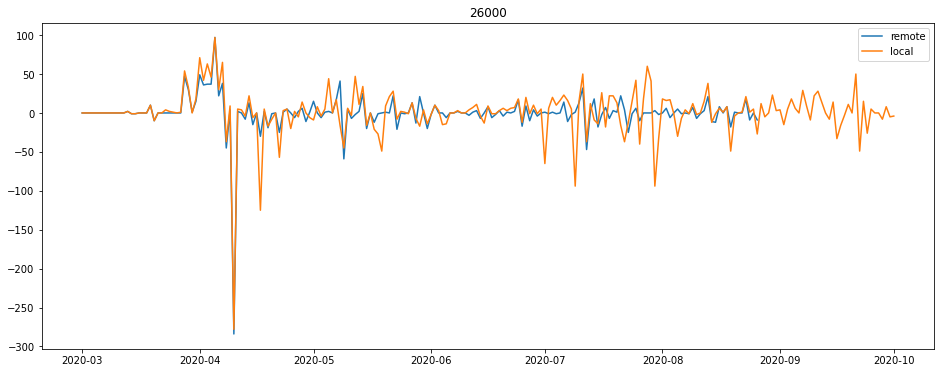

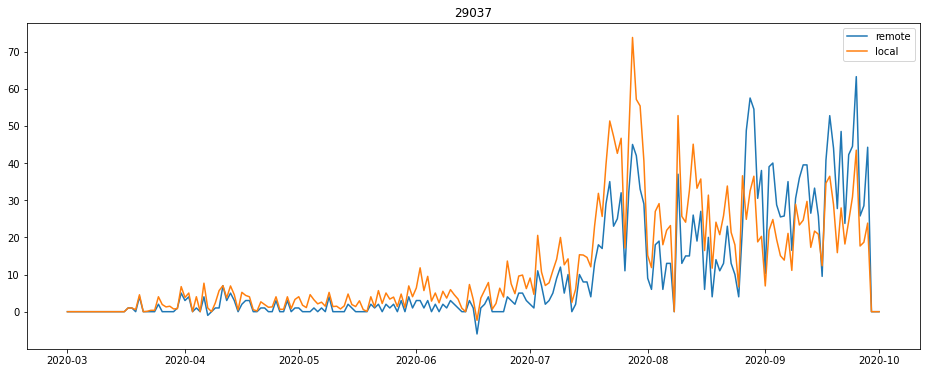

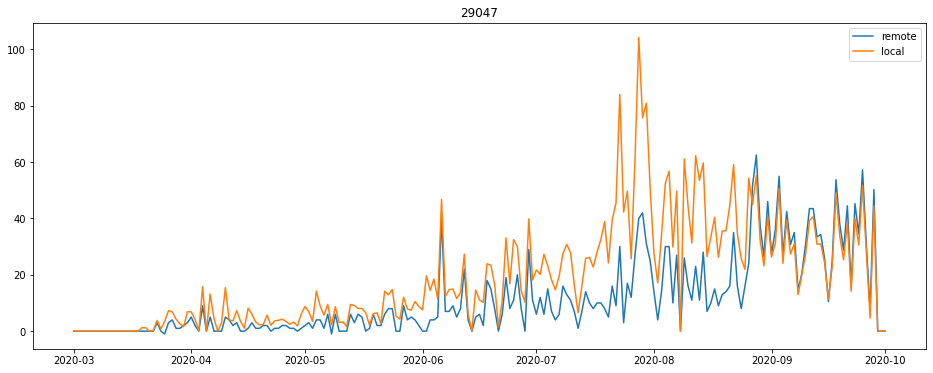

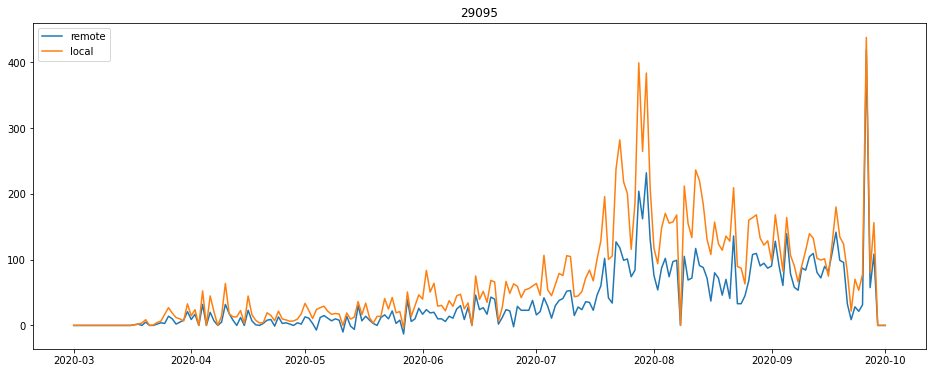

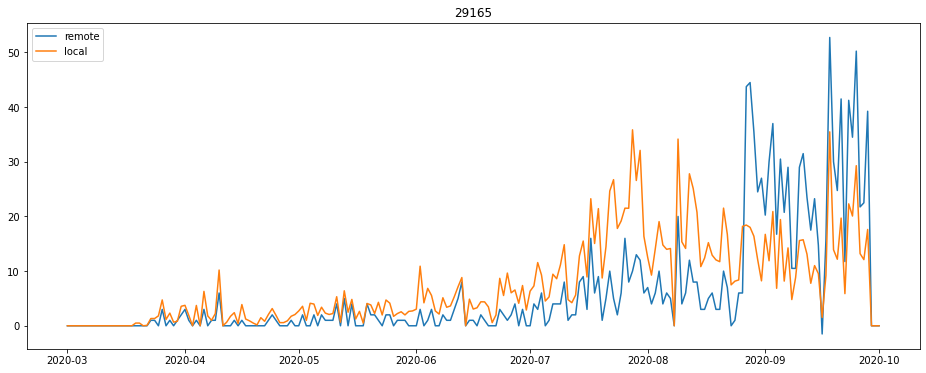

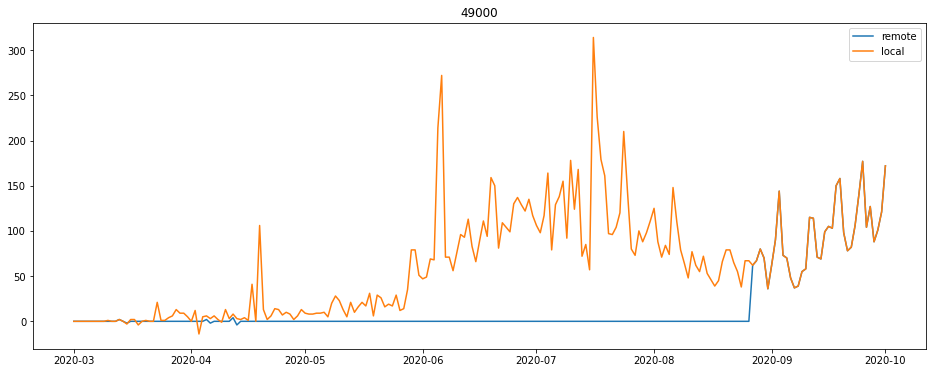

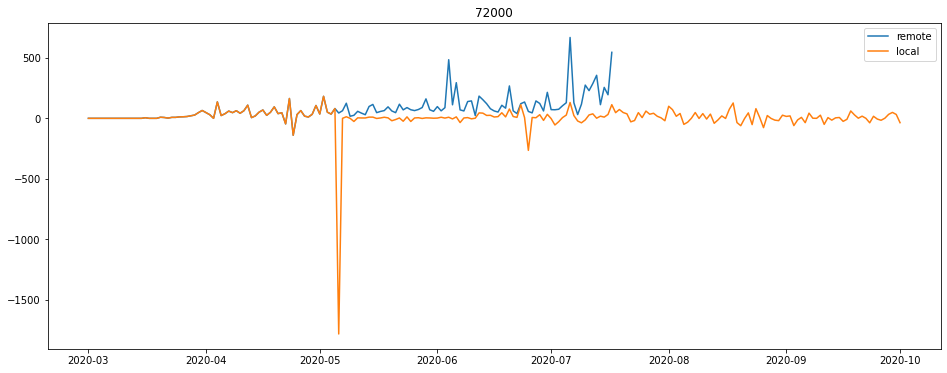

In [200]:
# The rest of the outliers
fips_codes = local_data["geo_id"].unique()
for fips_code in fips_codes:
    geo_code = fips_code
    rd = remote_data[remote_data["geo_value"] == geo_code].set_index("time_value").sort_index()["value"]
    ld = local_data[local_data["geo_id"] == geo_code].set_index("date").sort_index()["val"]
    max_percent_diff = rd.sub(ld).abs().max() / rd.abs().max()
    sum_percent_diff = rd.sub(ld).abs().sum() / rd.abs().sum()
    if abs(max_percent_diff) > .2 or sum_percent_diff > .2:
        print("Max percent difference for " + geo_code, max_percent_diff)
        plt.figure(figsize=(16, 6))
        plt.plot(rd, label="remote")
        plt.plot(ld, label="local")
        plt.title(geo_code)
        plt.legend()

### Load State Level Data

In [158]:
os.chdir(join(ROOT_DIR, "jhu"))
geocode = "state"
signal_type = "confirmed_incidence_num"
start_date = date(2020, 3, 1)
end_date = date(2020, 10, 1)
local_data = pd.concat(
        load_csvs(
            filter_filenames(
                read_relevant_date_filenames(
                    "receiving", 
                    generate_date_range(
                        start_date.strftime("%Y%m%d"), 
                        end_date.strftime("%Y%m%d")
                    )
                ),
                geocode,
                signal_type
            )
        )
    )

remote_data_filename = join(ROOT_DIR, "testing_utils", ( 
    start_date.strftime("%Y%m%d") + 
    "_" + 
    end_date.strftime("%Y%m%d") + 
    "jhu-csse_" + 
    "confirmed_incidence_num_" + 
    "state.csv"
))
if not isfile(remote_data_filename):
    remote_data = covidcast.signal("jhu-csse", "confirmed_incidence_num",
                            start_date, end_date,
                            "state")
    remote_data.to_csv(remote_data_filename)
else:
    remote_data = pd.read_csv(remote_data_filename)
remote_data["time_value"] = pd.to_datetime(remote_data["time_value"])

### State Level Plots

Max percent difference for al 0.9350567465321563
Max percent difference for ar 0.7088197146562906
Max percent difference for de 0.26327433628318586
Max percent difference for ga 0.31778058007566207
Max percent difference for id 0.7658181818181818
Max percent difference for il 0.20782350760103818
Max percent difference for ky 0.2682291666666667
Max percent difference for me 0.2857142857142857
Max percent difference for mn 0.4577319587628866
Max percent difference for ne 0.3432258064516129
Max percent difference for nh 0.3532110091743119
Max percent difference for nj 0.4478847884788479
Max percent difference for nm 0.608433734939759
Max percent difference for oh 0.5438963210702341
Max percent difference for ri 0.9007332205301748
Max percent difference for tn 0.48063858695652173
Max percent difference for vt 0.6375
Max percent difference for wy 0.43452380952380953


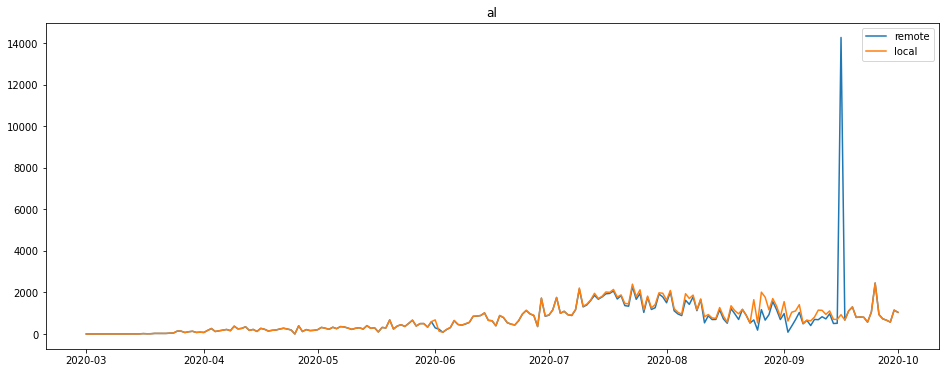

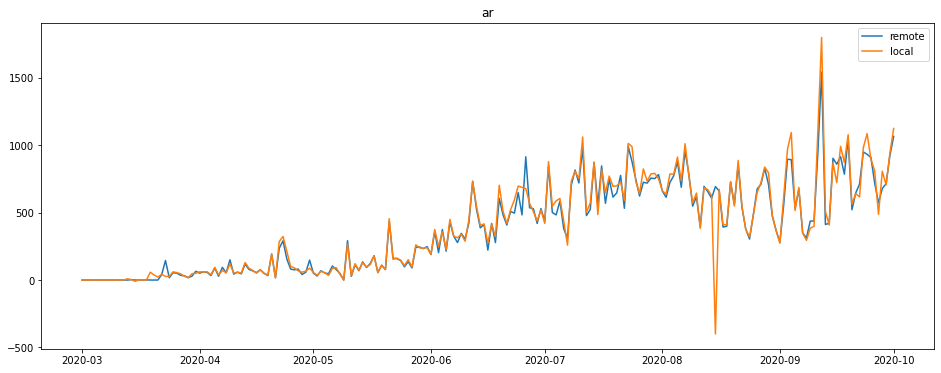

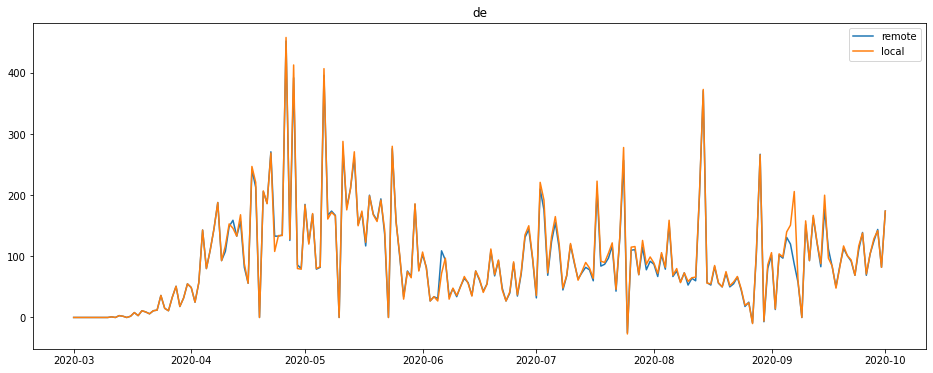

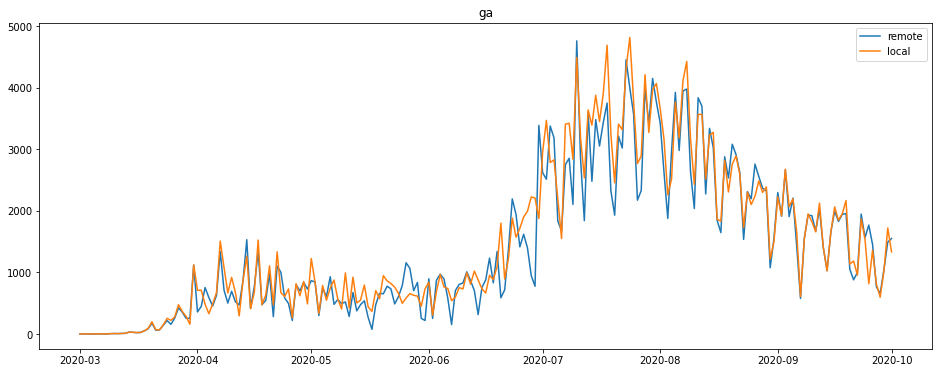

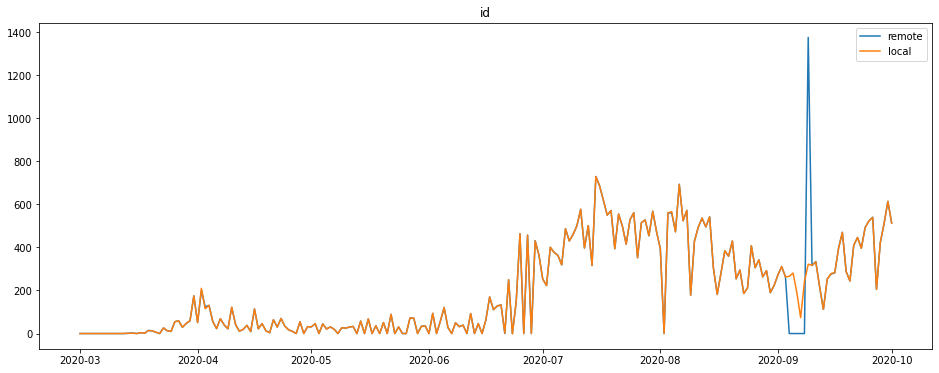

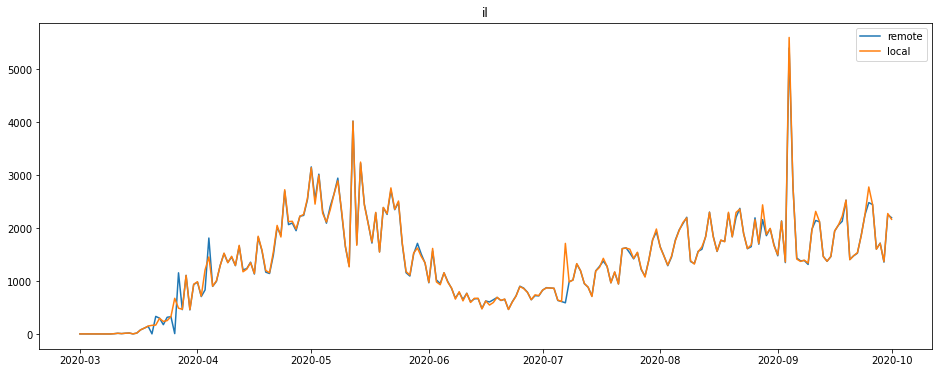

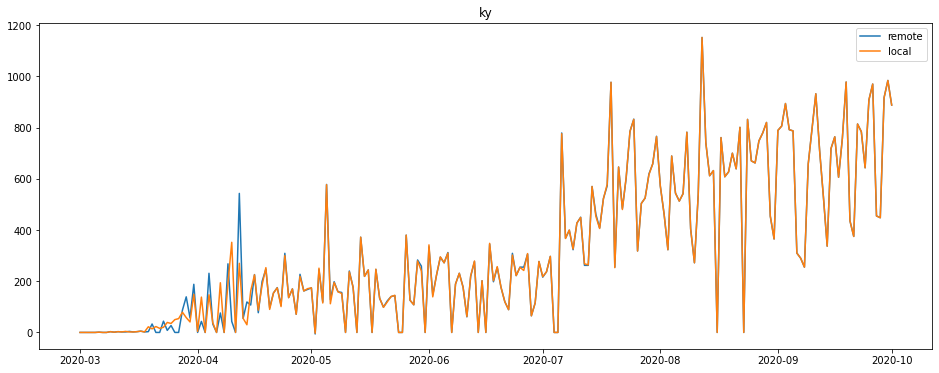

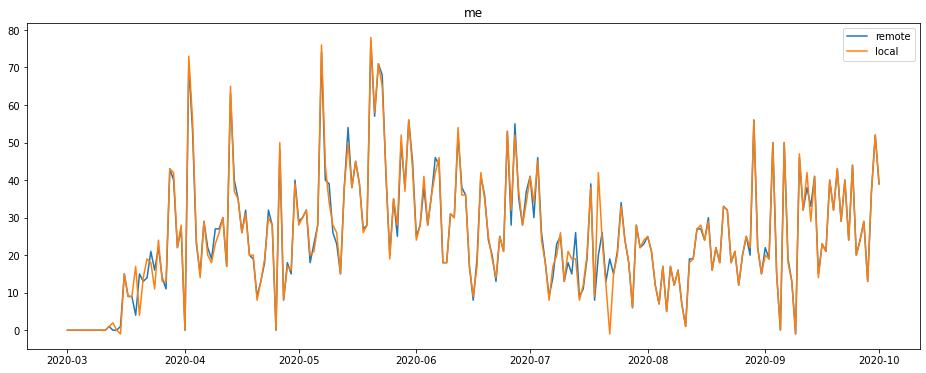

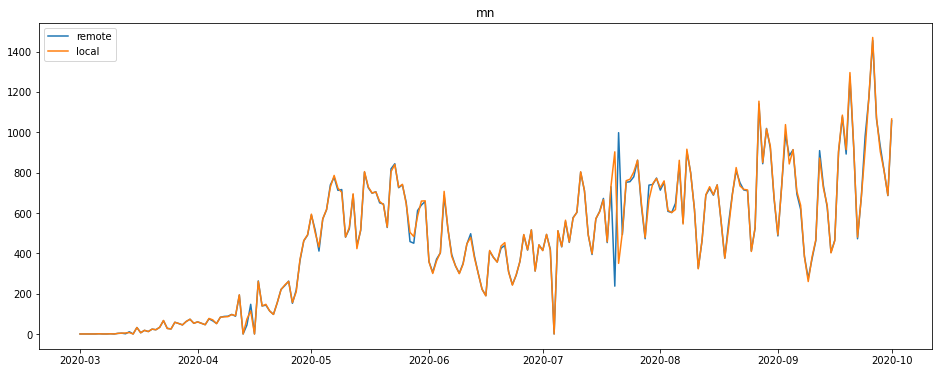

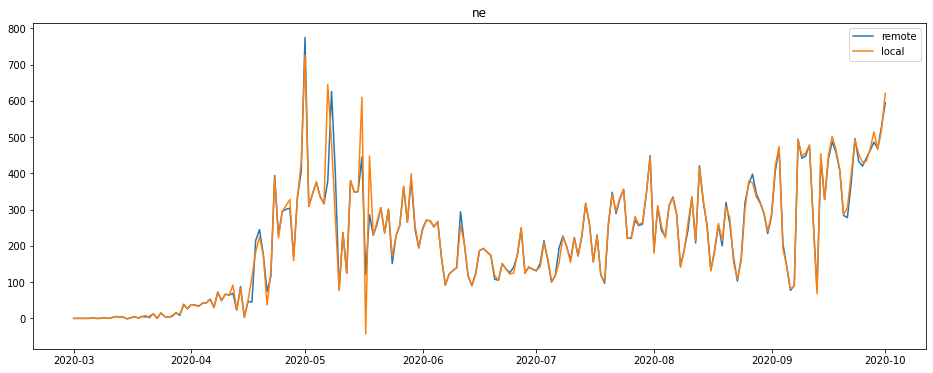

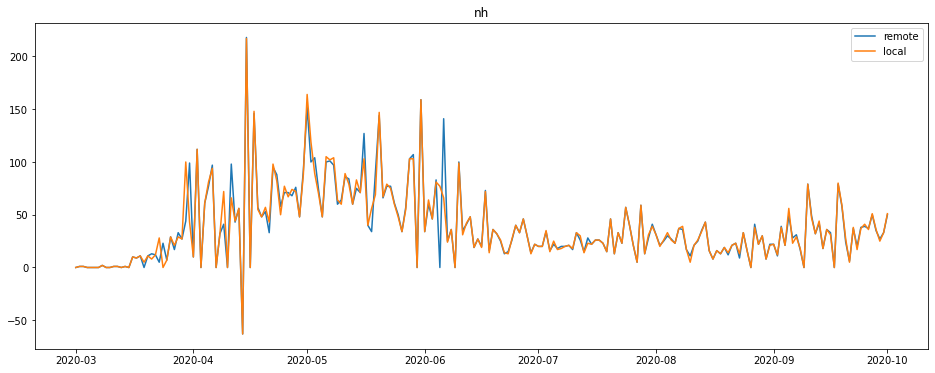

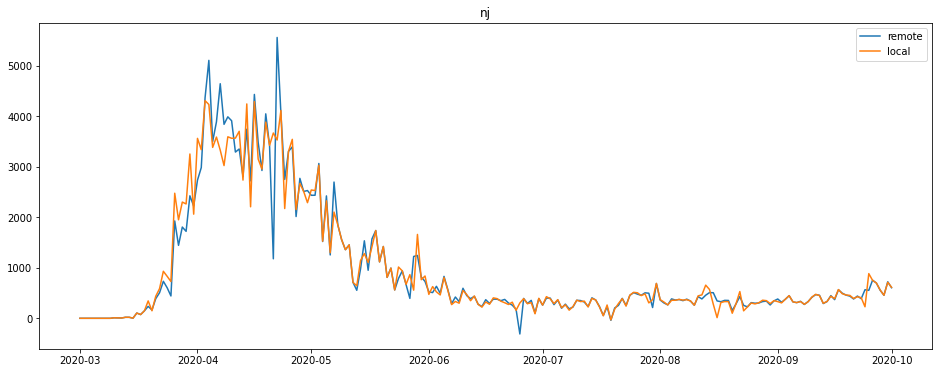

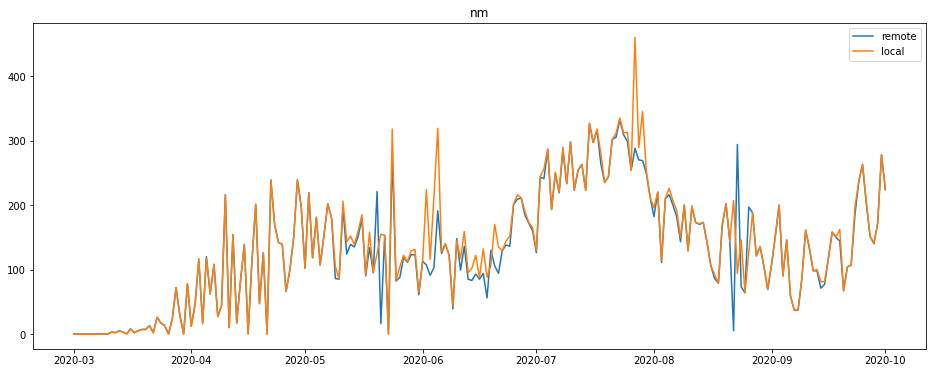

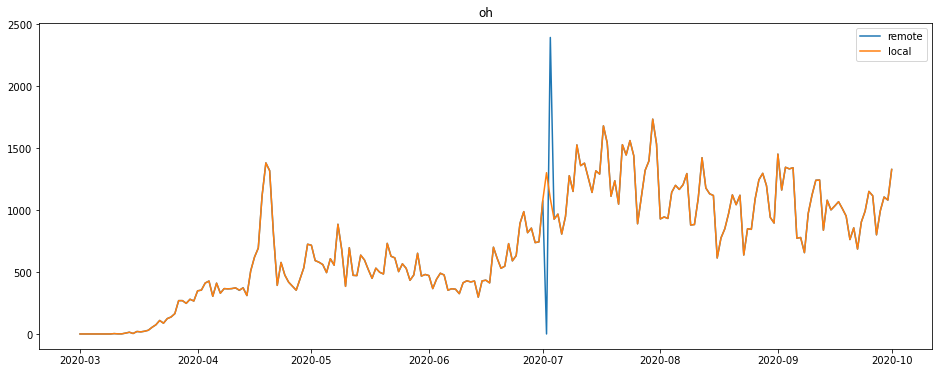

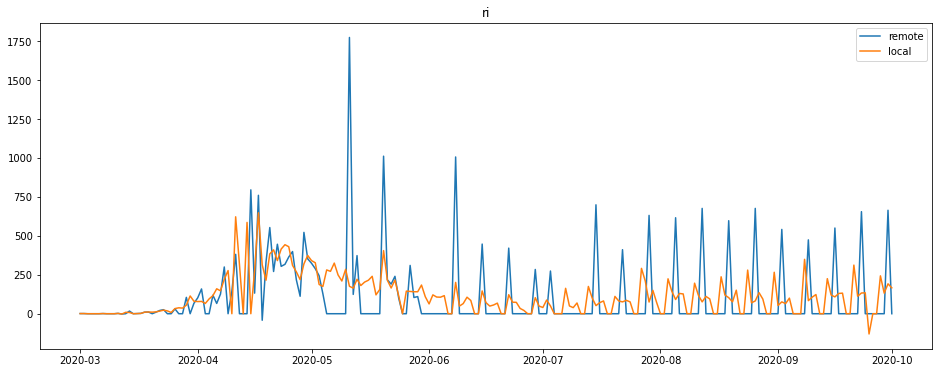

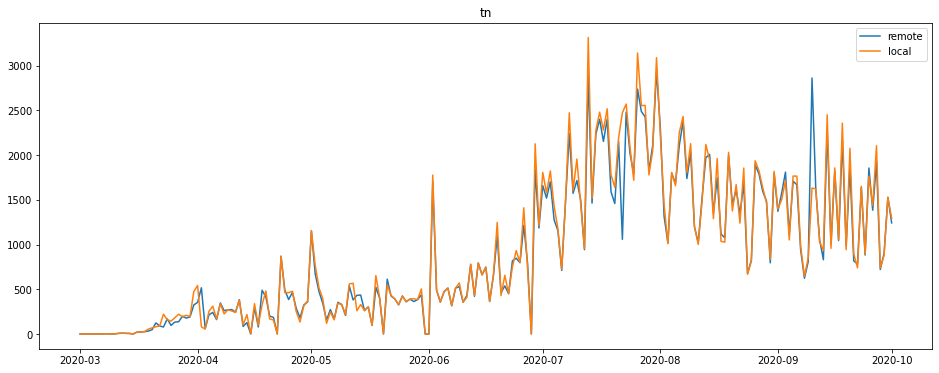

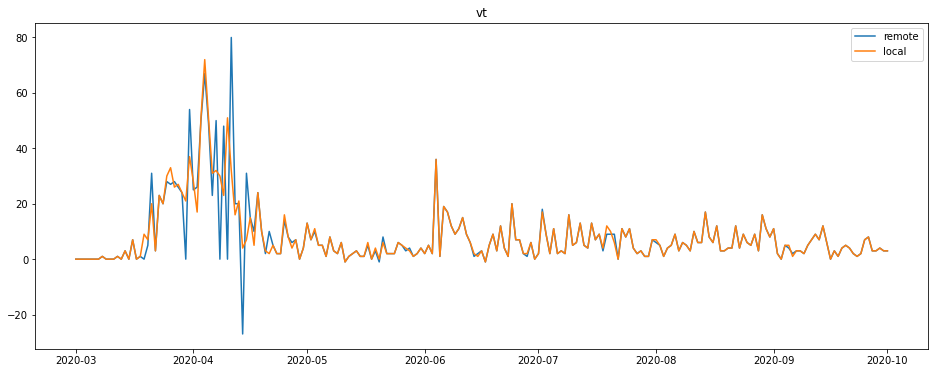

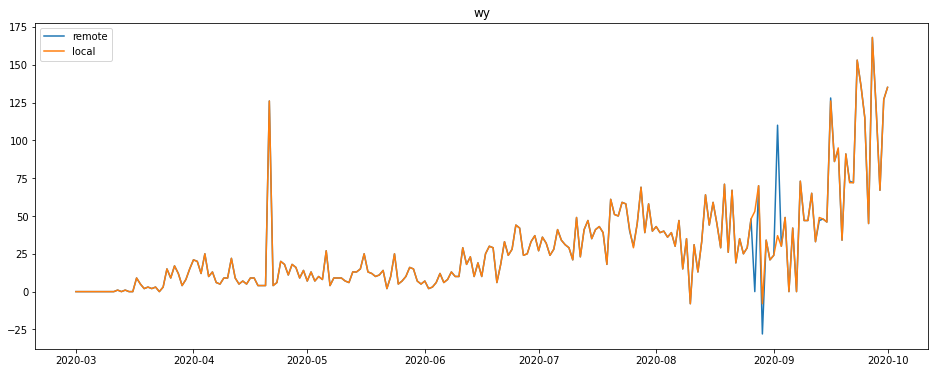

In [171]:
states = local_data["geo_id"].unique()
for state in states:
    geo_code = state
    rd = remote_data[remote_data["geo_value"] == geo_code].set_index("time_value").sort_index()["value"]
    ld = local_data[local_data["geo_id"] == geo_code].set_index("date").sort_index()["val"]
    max_percent_diff = rd.sub(ld).abs().max() / rd.abs().max()
    sum_percent_diff = rd.sub(ld).abs().sum() / rd.abs().sum()
    if abs(max_percent_diff) > .2 or sum_percent_diff > .2:
        print("Max percent difference for " + geo_code, max_percent_diff)
        plt.figure(figsize=(16, 6))
        plt.plot(rd, label="remote")
        plt.plot(ld, label="local")
        plt.title(geo_code)
        plt.legend()

### Load HRR Level Data

In [214]:
os.chdir(join(ROOT_DIR, "jhu"))
geocode = "hrr"
signal_type = "confirmed_incidence_num"
start_date = date(2020, 3, 1)
end_date = date(2020, 10, 1)
local_data = pd.concat(
        load_csvs(
            filter_filenames(
                read_relevant_date_filenames(
                    "receiving", 
                    generate_date_range(
                        start_date.strftime("%Y%m%d"), 
                        end_date.strftime("%Y%m%d")
                    )
                ),
                geocode,
                signal_type
            )
        )
    )

remote_data_filename = join(ROOT_DIR, "testing_utils", ( 
    start_date.strftime("%Y%m%d") + 
    "_" + 
    end_date.strftime("%Y%m%d") + 
    "jhu-csse_" + 
    "confirmed_incidence_num_" + 
    "hrr.csv"
))
if not isfile(remote_data_filename):
    remote_data = covidcast.signal("jhu-csse", "confirmed_incidence_num",
                            start_date, end_date,
                            "hrr")
    remote_data.to_csv(remote_data_filename)
else:
    remote_data = pd.read_csv(remote_data_filename)
remote_data["time_value"] = pd.to_datetime(remote_data["time_value"])

### HRR Level Plots

In [215]:
hrrs = local_data["geo_id"].unique()
for hrr in hrrs:
    geo_code = hrr
    rd = remote_data[remote_data["geo_value"] == geo_code].set_index("time_value").sort_index()["value"]
    ld = local_data[local_data["geo_id"] == geo_code].set_index("date").sort_index()["val"]
    max_percent_diff = rd.sub(ld).abs().max() / rd.abs().max()
    sum_percent_diff = rd.sub(ld).abs().sum() / rd.abs().sum()
    if abs(max_percent_diff) > .2 or sum_percent_diff > .2:
        print("Max percent difference for " + geo_code, max_percent_diff)
        plt.figure(figsize=(16, 6))
        plt.plot(rd, label="remote")
        plt.plot(ld, label="local")
        plt.title(geo_code)
        plt.legend()

### Load MSA Level Data

In [211]:
os.chdir(join(ROOT_DIR, "jhu"))
geocode = "msa"
signal_type = "confirmed_incidence_num"
start_date = date(2020, 3, 1)
end_date = date(2020, 10, 1)
local_data = pd.concat(
        load_csvs(
            filter_filenames(
                read_relevant_date_filenames(
                    "receiving", 
                    generate_date_range(
                        start_date.strftime("%Y%m%d"), 
                        end_date.strftime("%Y%m%d")
                    )
                ),
                geocode,
                signal_type
            )
        )
    )

remote_data_filename = join(ROOT_DIR, "testing_utils", ( 
    start_date.strftime("%Y%m%d") + 
    "_" + 
    end_date.strftime("%Y%m%d") + 
    "jhu-csse_" + 
    "confirmed_incidence_num_" + 
    "msa.csv"
))
if not isfile(remote_data_filename):
    remote_data = covidcast.signal("jhu-csse", "confirmed_incidence_num",
                            start_date, end_date,
                            "msa")
    remote_data.to_csv(remote_data_filename)
else:
    remote_data = pd.read_csv(remote_data_filename)
remote_data["time_value"] = pd.to_datetime(remote_data["time_value"])

### MSA Level Plots

In [212]:
msas = local_data["geo_id"].unique()
for msa in msas:
    geo_code = msa
    rd = remote_data[remote_data["geo_value"] == geo_code].set_index("time_value").sort_index()["value"]
    ld = local_data[local_data["geo_id"] == geo_code].set_index("date").sort_index()["val"]
    max_percent_diff = rd.sub(ld).abs().max() / rd.abs().max()
    sum_percent_diff = rd.sub(ld).abs().sum() / rd.abs().sum()
    if abs(max_percent_diff) > .2 or sum_percent_diff > .2:
        print("Max percent difference for " + geo_code, max_percent_diff)
        plt.figure(figsize=(16, 6))
        plt.plot(rd, label="remote")
        plt.plot(ld, label="local")
        plt.title(geo_code)
        plt.legend()